In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
plt.rcParams["figure.dpi"] = 120 # Make default figure size bigger

# Solution to Exercise 5: Crosshole traveltime tomography
Today, we want to look at a more realistic scenario. Consider two-boreholes spaced by 20 meters. The left one emits a seismic wave at 10 different depth positions. The waves, approximated as straight rays, are registered in the right borehole with 10 geophones (measurements of first arrival time). By inverting the traveltimes, we can estimate the slowness (or its reciprocal veclocity) distribution in the subsurface between the boreholes. The geometry looks like follows:

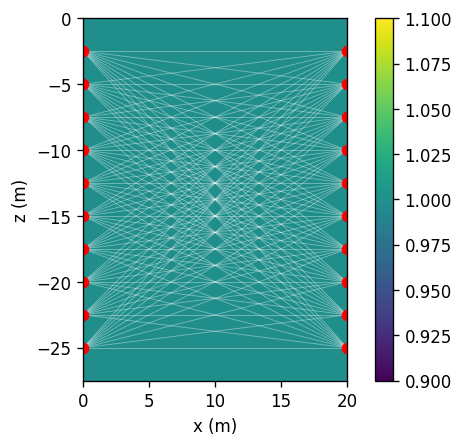

In [2]:
from crosshole import sensors, rays

def plot(m, label=""):
    fig, ax = plt.subplots()
    
    im = ax.imshow(m.reshape(44,32), extent=[0, 20, -27.5, 0])
    fig.colorbar(im, label=label)
    
    for ray in rays:
        xr = sensors[:, 0][ray]
        yr = sensors[:, 1][ray]
        ax.plot(xr, yr, "w-", lw=0.5, alpha=0.4)

    ax.plot(sensors[:,0], sensors[:,1], "ro")

    ax.set_aspect("equal")
    ax.set_ylabel("z (m)")
    ax.set_xlabel("x (m)")
    
plot(np.ones(44*32))

The parameter grid contains 44 rows and 32 columns, i.e. we are estimating 1408 subsurface parameters. Parameters are numbered like you would read a page of a book, i.e. the first is in the upper left corner and the last parameter in the lower right. 

The forward operator $\mathbf{G}$, the first-order smoothness operator $\mathbf{W}_m$ and the measured traveltimes $d$, are given and can be imported (provided that you have downloaded the `crosshole.py` and put it in the same folder as this notebook).

In [3]:
from crosshole import G, d, Wm

**1)** What type of inverse problem are we looking at?

**Solution**: Sensors are spaced by 2.5 meters, while there are 44 rows, hence a vertical grid spacing of 0.5 meters. Thus we have a number of small cells between sensors and in the upper and lower parts, which are not traversed by any ray, while cells close to the sensors are traversed by many rays $\rightarrow$ Mixed-determined.

**2)** Estimate and visualize the model parameters (i.e., slowness) or its reciprocal velocity. Start with a regularization strenght of 100. Does the model look physical to you?

*Hint*: Considering your estimated model vector is `m_est`. To visualize it in space, you can [reshape](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html) it into a matrix and [visualize](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.imshow.html) it with `ax.imshow(m_est_reshaped, extent=[0, 20, -27.5, 0])`. This is also implemented in the plot function we defined at the top of this notebook.

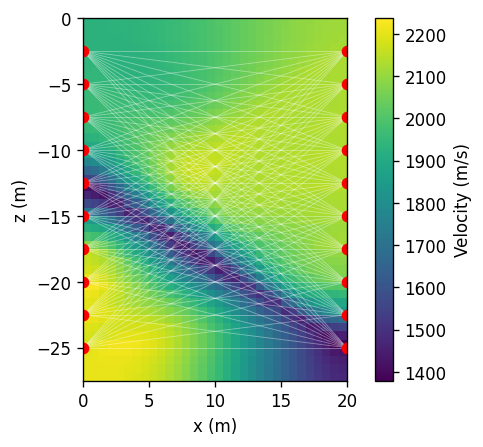

In [4]:
m_est = np.linalg.inv(G.T @ G + 100 * Wm.T @ Wm) @ G.T @ d
plot(1/m_est, label="Velocity (m/s)")

The model looks rather unphysical. The shape of the anomaly is very thin and narrow exactly traces one of the measurements, which suggests the data point is probably an outlier (e.g. due to measurement error).

**3)**: Does your model describe the data? Are there any obvious outliers? If yes, identify them on the basis of the prediction error. Make an associated plot, which shows the outlier(s). (**Hint**: You can use Numpy's [max](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.max.html?highlight=max#numpy.ndarray.max) function to return the maximum value of an array, and the [argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html?highlight=argmax#numpy.argmax) function to return that value's index - [min](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.min.html?highlight=min#numpy.ndarray.min) and [argmin](https://numpy.org/doc/stable/reference/generated/numpy.argmin.html?highlight=argmin#numpy.argmin) do the same for the minimum!)

Text(0.5, 0, 'Data number')

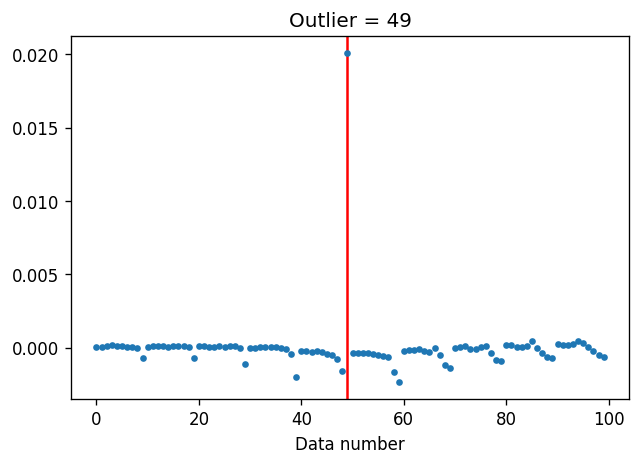

In [5]:
e = d - G @ m_est

fig, ax = plt.subplots()
index = np.argmax(np.abs(e)) # number of measurement with highest absolute prediction error
ax.set_title("Outlier = %d" % index)
ax.axvline(index, color="r")
ax.plot(e, ".")
ax.set_xlabel("Data number")

**4)**: Revisit 2) and incorporate data weighting. Give a weight of 0 to obivous outliers and a weight of 1 to the remaining traveltimes and estimate the model parameters again. Does the result look different?

**Hint**: You need to create and incorporate a data weighting matrix $\mathbf{W}_d$. The damped least-squares solution with data weighing looks like this: $\mathbf{G}^{-g}=(\mathbf{G}^T\mathbf{W}^T_d\mathbf{W}_d\mathbf{G}+\lambda \cdot\mathbf{W}^T_m\mathbf{W}_m)^{-1}\mathbf{G}^T\mathbf{W}^T_d\mathbf{W}_d$. More background on the data weighting matrix can be found in the sides to lecture 5.

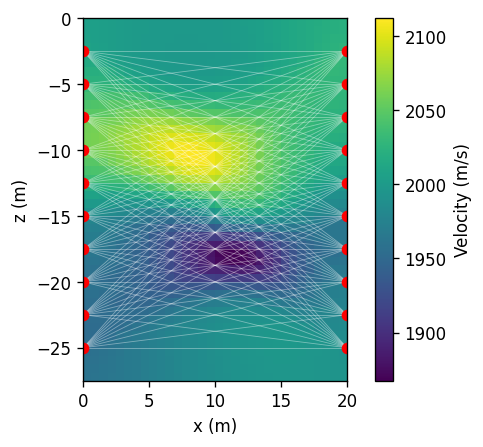

In [6]:
Wd = np.eye(len(G))
Wd[index,index] = 0
Ginv = np.linalg.inv(G.T @ Wd.T @ Wd @ G + 100 * Wm.T @ Wm) @ G.T @ Wd.T @ Wd
m_est2 = Ginv @ d
plot(1/m_est2, label="Velocity (m/s)")

If everything went smoothly, you should be able to see two anomalies: One with a velocity larger than 2000 m/s and one with a velocity lower than 2000 m/s.

**5)**: Plot the result for different (orders of magnitude of) regularization strengths and visualize the L-curve (prediction error vs. model roughness, i.e. $\mathbf{W}_m \mathbf{m}_{est}$). Can you identify an optimal regularization strength? 

**Hint**: By iterating over the beta-values you can efficiently create several plots. Use [np.logspace](https://numpy.org/doc/stable/reference/generated/numpy.logspace.html?highlight=logspace#numpy.logspace) or [np.geomspace](https://numpy.org/doc/stable/reference/generated/numpy.geomspace.html) to create logarithmically spaced value ranges for your beta.

In [7]:
betas = np.logspace(-5,5,20)
roughness = []
misfit = []
models = []
for beta in betas:
    m = np.linalg.inv(G.T @ Wd.T @ Wd @ G + beta * Wm.T @ Wm) @ G.T @ Wd.T @ Wd @ d
    models.append(m)
    roughness.append(np.linalg.norm(Wm @ m))
    misfit.append(np.linalg.norm(Wd@(d - G @ m)))

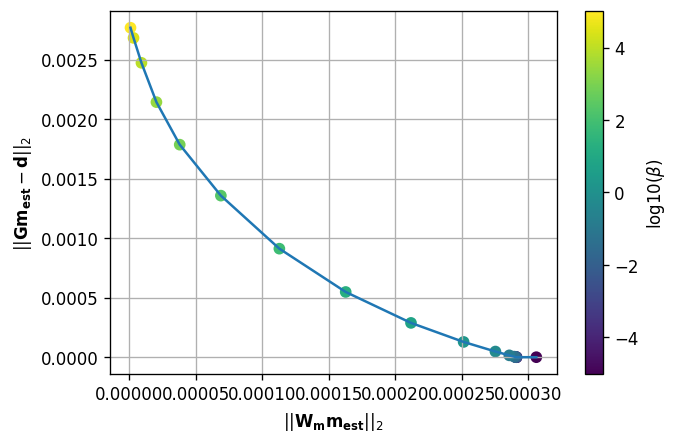

In [8]:
plt.plot(roughness, misfit)
plt.ylabel("$||\mathbf{Gm_{est}} - \mathbf{d}||_2$")
plt.xlabel("$||\mathbf{W_m m_{est}}||_2$")
plt.scatter(roughness, misfit, c=np.log10(betas))
plt.colorbar(label=r"log10($\beta$)")
plt.grid()

**6)**: Compute and visualize the model resolution (i.e., the diagonal of the model resolution matrix).
**Hint**: Use Numpy's [diag](https://numpy.org/doc/stable/reference/generated/numpy.diag.html?highlight=diag#numpy.diag) function to retrieve the diagonal of an array.

(1408, 1408)


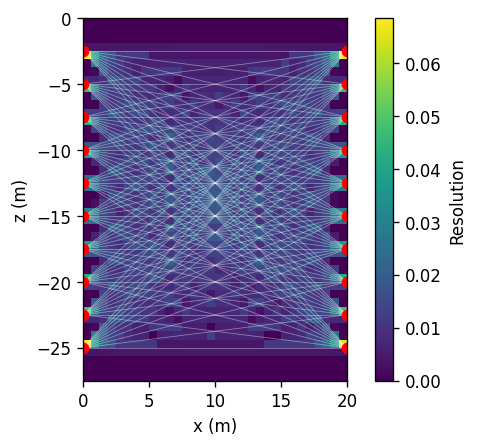

In [9]:
R = Ginv@G
print(np.shape(R))
Rdiag = np.diag(R)
plot(Rdiag, label="Resolution")

**7)**: Calculate the cumulative sensitivity, i.e. the sum of the lengths of all rays travelling to a particular cell. How does this cumulative sensitivity compare to the model resolution? What is the difference between both quantities?

Visualize the cells which are not traversed by any ray.

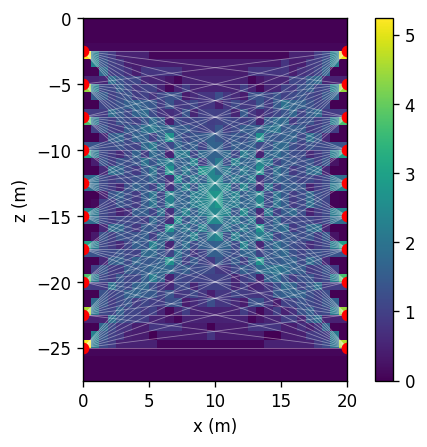

In [10]:
sens = G.T @ Wd.T @ Wd @ G
plot(np.diag(sens))

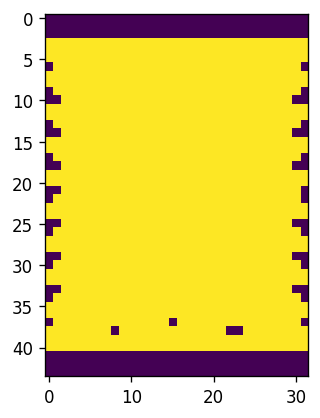

In [11]:
covered = np.diag(sens) > 0
plt.imshow(covered.reshape(44,32))